In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier

In [ ]:
def train_test_classes_split(dataset, target_key, train_sizes, random_state=None):
  X_tr = pd.DataFrame()
  X_ts = pd.DataFrame()
  y_tr = pd.DataFrame()
  y_ts = pd.DataFrame()

  for c in train_sizes.keys(): 
    ds = dataset[dataset[target_key] == c]
    y_c = ds[target_key]
    X_c = ds.drop(columns=target_key)
    X_tr_c, X_ts_c, y_tr_c, y_ts_c = train_test_split(X_c, y_c, 
                                                      random_state=random_state,
                                                      train_size=train_sizes[c])
    X_tr = pd.concat([X_tr, X_tr_c])
    X_ts = pd.concat([X_ts, X_ts_c])
    y_tr = pd.concat([y_tr, y_tr_c])
    y_ts = pd.concat([y_ts, y_ts_c])

  # print(X_tr_my.shape, X_ts_my.shape, y_tr_my.shape, y_ts_my.shape)
  return X_tr, X_ts, y_tr, y_ts

In [ ]:
def fit_predict_print(train, test, target_columns, estimator):
  X_tr = train.drop(columns=target_columns)
  y_tr = train[target_columns]
  X_ts = test.drop(columns=target_columns)
  y_ts = test[target_columns]

  return fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, estimator)

def fit_predict_print_1(X_train, X_test, y_train, y_test, estimator):
  y_pred = estimator.fit(X_train, y_train).predict(X_test)

  print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
  print('Confusion matrix:\n', metrics.confusion_matrix(y_test, y_pred))
  return y_test, y_pred

In [ ]:
def balanced_subsample(X, y, subsample_size=1.0):

    classes = y.unique()
    min_elems = y.value_counts().min()

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems * subsample_size)

    Xb = pd.DataFrame()
    yb = pd.Series()

    for c in classes:
      X_ = X[y == c]
      if X_.shape[0] > use_elems:
        X_ = X_.sample(use_elems)

      yc = np.empty(use_elems)
      yc.fill(c)
      y_ = pd.Series(yc)

      Xb = pd.concat([Xb, X_])
      yb = pd.concat([yb, y_])

    return Xb, yb

In [ ]:
def one_hot_encode(dataset, columns, drop=None):

  categories = []
  ret_columns = []

  if isinstance(columns, str):
    columns = [columns]
  if (drop is not None) and (isinstance(drop, str)):
    drop = [drop]

  for i in range(0, len(columns)):
    ctg = dataset.loc[:, columns[i]].unique().tolist()
    categories.append(ctg)

    ctg_ = ctg.copy();
    if drop is not None:
      ctg_.remove(drop[i])
    ret_columns += ctg_

  encoder = OneHotEncoder(categories=categories, drop=drop).fit(dataset[columns])
  ds = pd.DataFrame(encoder.transform(dataset[columns]).toarray(), columns=ret_columns)

  return ds

In [ ]:
def add_dummies(dataset, columns, drop_cat=None, drop_col=True):
  dummies = one_hot_encode(dataset, columns, drop_cat)
  if drop_col:
    dataset.drop(columns=columns, inplace=True)
  dataset = pd.concat([dataset, dummies], axis=1)
  return dataset

# Parte 1: Analisi

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BDA/data/new_weather.csv')

In [ ]:
dataset.head()

,Date,Max_Temperature_F,Mean_Temperature_F,Min_TemperatureF,Max_Dew_Point_F,MeanDew_Point_F,Min_Dewpoint_F,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_Pressure_In,Mean_Sea_Level_Pressure_In,Min_Sea_Level_Pressure_In,Max_Visibility_Miles,Mean_Visibility_Miles,Min_Visibility_Miles,Max_Wind_Speed_MPH,Mean_Wind_Speed_MPH,Events,Month,Year,Day
0,2014-10-13,71,62.0,54,55,51,46,87,68,46,30.03,29.79,29.65,10,10,4,13,4,Rain,10.0,2014.0,13.0
1,2014-10-14,63,59.0,55,52,51,50,88,78,63,29.84,29.75,29.54,10,9,3,10,5,Rain,10.0,2014.0,14.0
2,2014-10-15,62,58.0,54,53,50,46,87,77,67,29.98,29.71,29.51,10,9,3,18,7,Rain,10.0,2014.0,15.0
3,2014-10-16,71,61.0,52,49,46,42,83,61,36,30.03,29.95,29.81,10,10,10,9,4,Rain,10.0,2014.0,16.0
4,2014-10-17,64,60.0,57,55,51,41,87,72,46,29.83,29.78,29.73,10,10,6,8,3,Rain,10.0,2014.0,17.0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        689 non-null    object 
 1   Max_Temperature_F           689 non-null    int64  
 2   Mean_Temperature_F          688 non-null    float64
 3   Min_TemperatureF            689 non-null    int64  
 4   Max_Dew_Point_F             689 non-null    int64  
 5   MeanDew_Point_F             689 non-null    int64  
 6   Min_Dewpoint_F              689 non-null    int64  
 7   Max_Humidity                689 non-null    int64  
 8   Mean_Humidity               689 non-null    int64  
 9   Min_Humidity                689 non-null    int64  
 10  Max_Sea_Level_Pressure_In   689 non-null    float64
 11  Mean_Sea_Level_Pressure_In  689 non-null    float64
 12  Min_Sea_Level_Pressure_In   689 non-null    float64
 13  Max_Visibility_Miles        689 non

In [ ]:
dataset['Events'].value_counts()

Rain                   287
Fog                     16
Fog , Rain               7
Fog-Rain                 6
Rain-Thunderstorm        4
Rain , Thunderstorm      3
Snow                     2
Rain-Snow                2
Rain , Snow              1
Name: Events, dtype: int64

In [ ]:
dataset['Range_Temperature'] = dataset['Max_Temperature_F'] - dataset['Min_TemperatureF']

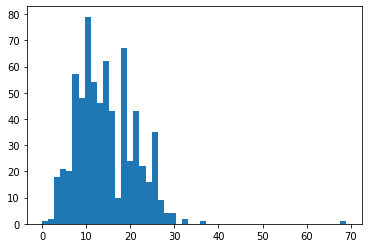

In [ ]:
_ = plt.hist(dataset['Range_Temperature'], bins=50)

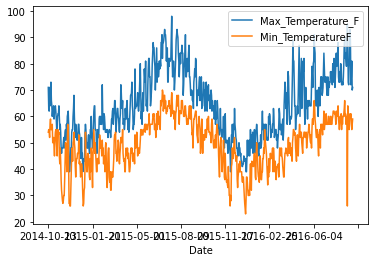

In [ ]:
dataset.plot(x='Date', y=['Max_Temperature_F', 'Min_TemperatureF'])

In [ ]:
dataset[~dataset['Events'].isna()]['Year'].value_counts()

2015.0    171
2016.0    104
2014.0     53
Name: Year, dtype: int64

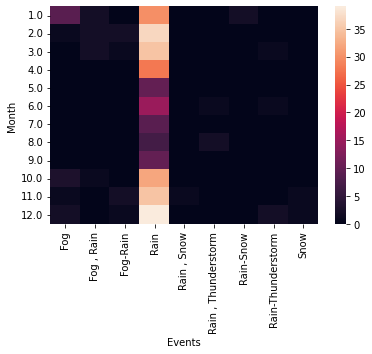

In [ ]:
xtab = pd.crosstab(dataset['Month'], dataset['Events'])
sns.heatmap(xtab)

In [ ]:
table = pd.pivot_table(dataset, values='Mean_Temperature_F', index=[dataset.Year, dataset.Month], columns=[dataset.Events])
table

Events              Fog  Fog , Rain  ...  Rain-Thunderstorm  Snow
Year   Month                         ...                         
2014.0 10.0         NaN         NaN  ...                NaN   NaN
       11.0         NaN         NaN  ...                NaN   NaN
       12.0   48.000000         NaN  ...                NaN   NaN
2015.0 1.0    45.833333        46.0  ...                NaN   NaN
       2.0          NaN        47.5  ...                NaN   NaN
       3.0          NaN        49.0  ...                NaN   NaN
       4.0          NaN         NaN  ...                NaN   NaN
       5.0          NaN         NaN  ...                NaN   NaN
       6.0          NaN         NaN  ...                NaN   NaN
       7.0          NaN         NaN  ...                NaN   NaN
       8.0          NaN         NaN  ...                NaN   NaN
       9.0          NaN         NaN  ...                NaN   NaN
       10.0   55.666667        62.0  ...                NaN   NaN
       11.0   34.000000         NaN  ...                NaN  36.0
       12.0         NaN         NaN  ...               51.0  42.0
2016.0 1.0    38.666667         NaN  ...                NaN   NaN
       2.0    50.000000         NaN  ...                NaN   NaN
       3.0          NaN         NaN  ...               44.0   NaN
       4.0          NaN         NaN  ...                NaN   NaN
       5.0          NaN         NaN  ...                NaN   NaN
       6.0          NaN         NaN  ...               66.0   NaN
       7.0          NaN         NaN  ...                NaN   NaN
       8.0          NaN         NaN  ...                NaN   NaN

[23 rows x 9 columns]

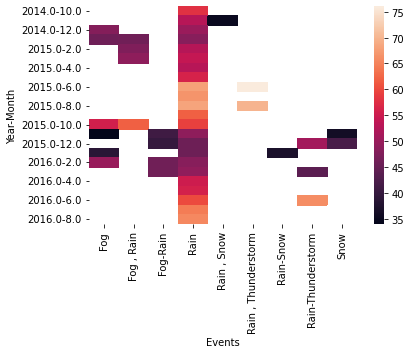

In [ ]:
sns.heatmap(table)

In [ ]:
dataset0 = dataset.copy()

In [ ]:
dataset['Events'] = np.where(dataset['Events'].isna(), 0, 1)
dataset.drop(columns='Date', inplace=True)
dataset.dropna(inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Max_Temperature_F           688 non-null    int64  
 1   Mean_Temperature_F          688 non-null    float64
 2   Min_TemperatureF            688 non-null    int64  
 3   Max_Dew_Point_F             688 non-null    int64  
 4   MeanDew_Point_F             688 non-null    int64  
 5   Min_Dewpoint_F              688 non-null    int64  
 6   Max_Humidity                688 non-null    int64  
 7   Mean_Humidity               688 non-null    int64  
 8   Min_Humidity                688 non-null    int64  
 9   Max_Sea_Level_Pressure_In   688 non-null    float64
 10  Mean_Sea_Level_Pressure_In  688 non-null    float64
 11  Min_Sea_Level_Pressure_In   688 non-null    float64
 12  Max_Visibility_Miles        688 non-null    int64  
 13  Mean_Visibility_Miles       688 non

In [ ]:
train, test = train_test_split(dataset, train_size=2/3, random_state=1)

In [ ]:
_ = fit_predict_print(train, test, 'Events', BernoulliNB())

Accuracy: 0.5391304347826087
Confusion matrix:
 [[114   1]
 [105  10]]


In [ ]:
_ = fit_predict_print(train, test, 'Events', DecisionTreeClassifier())

Accuracy: 0.7695652173913043
Confusion matrix:
 [[84 31]
 [22 93]]


In [ ]:
X = dataset.drop(columns='Events')
y = dataset['Events']

In [ ]:
cross_val_score(BernoulliNB(), X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

0.5595055413469736

In [ ]:
cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

0.744458653026428

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

def models():
    models = []
    models.append(('LR'   , LogisticRegression()))
    models.append(('LDA'  , LinearDiscriminantAnalysis()))
    models.append(('KNN'  , KNeighborsClassifier()))
    models.append(('CART' , DecisionTreeClassifier()))
    models.append(('NB'   , GaussianNB()))
    models.append(('SVM'  , SVC(probability=True)))
    models.append(('AB'   , AdaBoostClassifier()))
    models.append(('GBM'  , GradientBoostingClassifier()))
    models.append(('RF'   , RandomForestClassifier()))
    models.append(('ET'   , ExtraTreesClassifier()))
    return models

In [ ]:
from sklearn.model_selection import StratifiedKFold

def cross_val_models(X, y, models=models(), num_folds=10, random_state=None, 
                     scoring = 'accuracy'):
    names = []
    results = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state=random_state, shuffle=True)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=-1)
        names.append(name)
        results.append(cv_results)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [ ]:
names, results = cross_val_models(X, y, models())

LR: 0.860614 (0.042303)
LDA: 0.866326 (0.038085)
KNN: 0.815601 (0.058412)
CART: 0.802387 (0.028738)
NB: 0.799510 (0.034364)
SVM: 0.523274 (0.003069)
AB: 0.856138 (0.031901)
GBM: 0.853197 (0.038051)
RF: 0.844459 (0.033948)
ET: 0.853282 (0.053538)


In [ ]:
models_performance = pd.DataFrame(np.array(results).T, columns=names)
models_performance.describe()

,LR,LDA,KNN,CART,NB,SVM,AB,GBM,RF,ET
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.860614,0.866326,0.815601,0.802387,0.799510,0.523274,0.856138,0.853197,0.844459,0.853282
std,0.044592,0.040145,0.061572,0.030293,0.036223,0.003235,0.033627,0.040110,0.035784,0.056434
min,0.782609,0.797101,0.724638,0.724638,0.739130,0.521739,0.782609,0.797101,0.782609,0.753623
25%,0.844203,0.836957,0.768116,0.797101,0.782609,0.521739,0.844203,0.826087,0.829710,0.807385
50%,0.869565,0.882353,0.826087,0.804348,0.802962,0.521739,0.861360,0.852941,0.847826,0.862319
75%,0.890185,0.894928,0.850863,0.823529,0.822464,0.521739,0.879955,0.869565,0.875533,0.894928
max,0.926471,0.913043,0.926471,0.826087,0.852941,0.529412,0.898551,0.913043,0.884058,0.926471


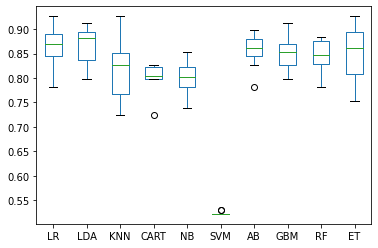

In [ ]:
_ = models_performance.plot(kind='box')

8. Creare un nuovo dataset “reduced” con esclusivamente i valori medi degli indicatori
atmosferici. Per ogni feature, dividere il range dei valori in 6 gruppi. Sostituire al valore
originale dell’attributo un numero che va da 1 a 6 e che indica l’appartenenza allo specifico
gruppo. Valutare l’accuratezza ottenuta con un qualsiasi algoritmo utilizzato in precedenza

In [ ]:
dataset.columns

Index(['Max_Temperature_F', 'Mean_Temperature_F', 'Min_TemperatureF',
       'Max_Dew_Point_F', 'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_Pressure_In',
       'Mean_Sea_Level_Pressure_In', 'Min_Sea_Level_Pressure_In',
       'Max_Visibility_Miles', 'Mean_Visibility_Miles', 'Min_Visibility_Miles',
       'Max_Wind_Speed_MPH', 'Mean_Wind_Speed_MPH', 'Events', 'Month', 'Year',
       'Day', 'Range_Temperature'],
      dtype='object')

In [ ]:
reduced = dataset.drop(columns=['Max_Temperature_F', 'Min_TemperatureF',
                                'Max_Dew_Point_F', 'Min_Dewpoint_F', 
                                'Max_Humidity', 'Min_Humidity', 
                                'Max_Sea_Level_Pressure_In', 'Min_Sea_Level_Pressure_In',
                                'Max_Visibility_Miles', 'Min_Visibility_Miles',
                                'Max_Wind_Speed_MPH'])

In [ ]:
reduced.columns

Index(['Mean_Temperature_F', 'MeanDew_Point_F', 'Mean_Humidity',
       'Mean_Sea_Level_Pressure_In', 'Mean_Visibility_Miles',
       'Mean_Wind_Speed_MPH', 'Events', 'Month', 'Year', 'Day',
       'Range_Temperature'],
      dtype='object')

In [ ]:
to_cut = ['Mean_Temperature_F', 'MeanDew_Point_F', 'Mean_Humidity',
       'Mean_Sea_Level_Pressure_In', 'Mean_Visibility_Miles',
       'Mean_Wind_Speed_MPH', 'Range_Temperature']
# non suddivido Year, Month, Date

for c in to_cut: 
  reduced[c] = pd.cut(reduced[c], 6, labels=[1, 2, 3, 4, 5, 6])

reduced.head()

,Mean_Temperature_F,MeanDew_Point_F,Mean_Humidity,Mean_Sea_Level_Pressure_In,Mean_Visibility_Miles,Mean_Wind_Speed_MPH,Events,Month,Year,Day,Range_Temperature
0,4,6,4,2,6,2,1,10.0,2014.0,13.0,2
1,4,6,5,2,6,2,1,10.0,2014.0,14.0,1
2,3,6,5,2,6,3,1,10.0,2014.0,15.0,1
3,4,5,4,3,6,2,1,10.0,2014.0,16.0,2
4,4,6,5,2,6,2,1,10.0,2014.0,17.0,1


In [ ]:
X = reduced.drop(columns='Events')
y = reduced['Events']

In [ ]:
cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

0.7907502131287296

In [ ]:
train, test = train_test_split(reduced, train_size=.75, random_state=1)

In [ ]:
dataset1 = train[train['Month'].between(1, 4)]
dataset2 = train[train['Month'].between(5, 8)]
dataset3 = train[train['Month'].between(9, 12)]

In [ ]:
dataset1.drop(columns='Month', inplace=True)
dataset2.drop(columns='Month', inplace=True)
dataset3.drop(columns='Month', inplace=True)
test.drop(columns='Month', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
clf1 = DecisionTreeClassifier().fit(dataset1.drop(columns='Events'), dataset1['Events'])
clf2 = DecisionTreeClassifier().fit(dataset2.drop(columns='Events'), dataset2['Events'])
clf3 = DecisionTreeClassifier().fit(dataset3.drop(columns='Events'), dataset3['Events'])

In [ ]:
vc = VotingClassifier([('clf1', clf1), ('clf2', clf2), ('clf3', clf3)])
# can only fit on the same dataset, not one specific for each classifier

In [ ]:
X_tr_1 = dataset1.drop(columns='Events')
y_tr_1 = dataset1['Events']
X_tr_2 = dataset2.drop(columns='Events')
y_tr_2 = dataset2['Events']
X_tr_3 = dataset3.drop(columns='Events')
y_tr_3 = dataset3['Events']

In [ ]:
def voting_classifier(estimators, X_train_list, y_train_list, X_test):
    
    preds = np.asarray([clf.fit(X, y).predict(X_test) for clf, X, y in 
                        zip(estimators, X_train_list, y_train_list)])
    modes = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 
                                axis=0, arr=preds)
    
    return modes

In [ ]:
y_pr = voting_classifier([clf1, clf2, clf3], [X_tr_1, X_tr_2, X_tr_3], [y_tr_1, y_tr_2, y_tr_3],
                  test.drop(columns='Events'))

In [ ]:
y_ts = test['Events']

In [ ]:
metrics.accuracy_score(y_ts, y_pr)

0.6976744186046512

10. Effettuare (e giustificare) una variazione a piacere del dataset e calcolare l’accuratezza ottenuta dal nuovo dataset

In [ ]:
dataset = dataset0.copy()

In [ ]:
dataset['Range_Temperature'] = dataset['Max_Temperature_F'] - dataset['Min_TemperatureF']
dataset['Events'] = np.where(dataset['Events'].isna(), 0, 1)
dataset.drop(columns=['Date', 'Year', 'Day'], inplace=True)
dataset.drop(columns=[
                      'Max_Temperature_F', 'Min_TemperatureF',
                      'Max_Dew_Point_F', 'Min_Dewpoint_F', 
                      'Max_Humidity', 'Min_Humidity', 
                      'Max_Sea_Level_Pressure_In', 'Min_Sea_Level_Pressure_In',
                      'Max_Visibility_Miles', 'Min_Visibility_Miles',
                      'Max_Wind_Speed_MPH'], inplace=True)

dataset.dropna(inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [ ]:
dataset.describe()

,Mean_Temperature_F,MeanDew_Point_F,Mean_Humidity,Mean_Sea_Level_Pressure_In,Mean_Visibility_Miles,Mean_Wind_Speed_MPH,Events,Month,Range_Temperature
count,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000
mean,56.584302,45.014535,68.486919,30.034637,9.428779,4.604651,0.476744,6.357558,14.594477
std,10.408058,7.917502,12.700668,0.197619,1.175013,2.692505,0.499822,3.482132,6.608611
min,33.000000,4.000000,24.000000,29.310000,1.000000,0.000000,0.000000,1.000000,2.000000
25%,48.000000,41.000000,60.000000,29.930000,9.000000,3.000000,0.000000,3.000000,10.000000
50%,56.000000,46.000000,70.000000,30.040000,10.000000,4.000000,0.000000,6.000000,13.000000
75%,65.000000,51.000000,79.000000,30.160000,10.000000,6.000000,1.000000,9.250000,19.000000
max,83.000000,59.000000,95.000000,30.810000,10.000000,15.000000,1.000000,12.000000,69.000000


In [ ]:
train, test = train_test_split(dataset, train_size=.75, random_state=1)

In [ ]:
_ = fit_predict_print(train, test, 'Events', DecisionTreeClassifier())

Accuracy: 0.7383720930232558
Confusion matrix:
 [[66 25]
 [20 61]]


In [ ]:
X = dataset.drop(columns='Events')
y = dataset.Events

In [ ]:
cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

0.8037936913895992

In [ ]:
def boxplot_models_performance(X, y, models=models(), num_folds=10, random_state=None, 
                     scoring = 'accuracy'):
  names, results = cross_val_models(X, y, models, num_folds, random_state, scoring)
  pd.DataFrame(np.array(results).T, columns=names).plot(kind='box')

LR: 0.832843 (0.052203)
LDA: 0.835784 (0.035504)
KNN: 0.794949 (0.066201)
CART: 0.763193 (0.038332)
NB: 0.829945 (0.037800)
SVM: 0.807992 (0.052461)
AB: 0.834250 (0.045230)
GBM: 0.813981 (0.042827)
RF: 0.816901 (0.047644)
ET: 0.821249 (0.030268)


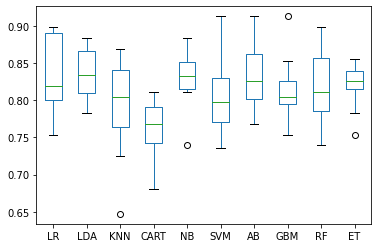

In [ ]:
boxplot_models_performance(X, y)